# Object Detection For Species Classification

by Jamie McElhiney

## Problem Statement

Around 12% of current bird species are considered endangered, threatened or vulnerable in some way. Many birds play a crucial roll in ecological systems for both predator and prey. Bird species such as these are known as 'keystone species' that hold an invaluable presence in their respective ecosystems. For example, a lot of birds are host to a variety of parasites and flys that also hold weight within their food chains. Additionally, many birds aid in pollination of certain plant species and creation of subhabitats such as nests or entry points in trees (woodpecker). It is incredibly important to conserve these species for both ecological and humane reasons. Not to mention, birds are peculiar and amusing to us. It would be a shame to go out on a walk and not hear the specific chirping melody based on the regional species.  

What we can do is propose a habitat protection movement. Habitat loss and destruction are one of the leading causes of bird species extinction. We can discretely place cameras in areas we know there may be endangered species and are being considered for deforestation or other means of habitat disruption.   

We will attempt to train our own bird detection system so that we can appropriately assess the population and activity of specific species within our geographical regions of study. To do this, we will segment out our bird images with a selective search algorithm and use a CNN to classify these segments as foreground(our bird) or background, so it will be a binary classification. Our metric we will evaluate our model on is accuracy. When we deploy our model, we will be able to localize our bird on a variety of images. This will help conservation efforts since we can deploy cameras that will detect various bird species that could be endangered without human disruption.

## Executive Summary

We used a combination of images from Cal-Tech's bird data set . Cal-Tech's bird data set includes 200 species of around 80 images per species. We have abridged the dataset to 6 species of around 60 images per species. The species we will be considering include a Cardinal, Gadwall, Horned Grebe, Blue Jay, Red-winged Blackbird, and Western Meadowlark. The intended outcome of our study is to analyze various methods of segmentation and object detection, as opposed to produced a highly accurate bird classification model. Image segmentation allows us to extract and separate different regions within our image. We are going to apply a selective search approach. We will then apply and evaluate a Convolutional Neural Network that will help us determine which segments are of interest (bird) and which are not (background noise)

Selective Search
- Diverse application of grouping/segmentation algorithms based on color/texture/shape  
- Proposes multiple regions of interest  
- Heirarchical 


As with many image recognition and object detection problems, we run into many recurrent and expected problems. We must consider how we will account for birds with different poses, facing different directions, leaning forwards or backwards, facing the camera or facing away, flying or standing, and so on. If we feed in images of birds in only certain poses, lets say all facing left, how will our detection system recognize a bird facing right. We also have to considered different background classes. Different bird species will habit different genres of terrain(what region are these species found in), and similarly we have to account for what season it is, weather conditions, time of day, lighting, etc.. We have accounted for some of these issues with data augmentation where we have generated copies of our original data with added noise that can be considered synonymous with camera inconsistencies (scratching,dust) and orientation flips (pose left,right). 

For both approaches, we fit and evaluated various classification algorithms in a binary setting (foreground,background). We use our annotated boundary boxes on our birds so we can retrieve suggested candidate regions for foreground objects. We calculated an Intersection over Union score (IoU) to determine how overlapped our proposed regions by our segmentation method are with our ground truth (annoted labels) box. Regions with a score greater than 0.7 would be classified as foreground and regions with a score less than 0.3 would be classified as background. It should be noted that all regions had to be resized to 224x224, as we can only train a model on observations of the same size. For resizing, the specific method of resizing cv2's inter_area, appropriately resizes based on wether the image was shrunken or enlarged from original size to specified resize dimensions. Our classification model consists out a multi layer Convalutional Network connected to a Fully Connected layer.

## Data Dictionary

| Name| Data Types (Pandas) | Description |
|---|---|---|
|root|object|root file path of image|
|filename|object|full filename plus doc ext of image file|
|w|int64|width of image|
|h|int64|height of image|
|x1|int64|first x-coordinate of bounding box|
|y1|int64|first y-coordinate of bounding box|
|x2|int64|second x-coordinate of bounding box|
|y2|int64|second y-coordinate of bounding box|


In [2]:
import tensorflow as tf
import IPython.display as display

In [3]:

import base64
from PIL import Image
import io

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9866447940108539609
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3135687884
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8612438929666365526
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sn
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten,Dense, ZeroPadding2D, Dropout, Input,BatchNormalization
from keras.callbacks import EarlyStopping
from keras import backend as K

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, auc,roc_curve, roc_auc_score

from sklearn.preprocessing import LabelBinarizer

import xml.etree.ElementTree as ET
import random

Using TensorFlow backend.


In [5]:
#load data with pandas
train_path='./data/bird2_train/'
test_path='./data/bird2_test/'

## Read in CVAT annotion file with XML parser

We performed annotations (labeled boundary boxes) on our images around birds so we can set up an object detection model. These annotations were performed in Computer Vision Annotation Tool (CVAT). CVAT spits out an XML containing our image metadata, such as image heigh, image width, boundary box coordinates, filename, and root filepath. We will parse through this XML with xml tree and create our initial dataframe.

In [6]:
def create_df_xml(input1):
    annotation=ET.parse(f'../data/bird2_{input1}/{input1}_annotations.xml')
    root=annotation.getroot()
    df_cols=['root','filename','w','h']
    df_rows=[]
    for node in root.iter('image'):
        #print (list(node.attrib.values()))
        s_root=f'../data/bird2_{input1}/'
        s_name=list(node.attrib.values())[1]
        s_height=list(node.attrib.values())[3]
        s_width=list(node.attrib.values())[2]
         
        
    
        df_rows.append({'root':s_root,'filename': s_name,'w':s_width,'h':s_height,
                            })
        x1=pd.DataFrame(df_rows, columns = df_cols)
    df_cols=['x1','x2','y1','y2']
    df_rows=[]
    for node in root.iter('image'):
        for node1 in node:
            s_x1=list(node1.attrib.values())[2]
            s_x2=list(node1.attrib.values())[4]
            s_y1=list(node1.attrib.values())[3]
            s_y2=list(node1.attrib.values())[5]
   
            df_rows.append({
                            'x1':s_x1,'x2':s_x2,'y1':s_y1,'y2':s_y2})
        x2=pd.DataFrame(df_rows,columns=df_cols)
    x4= pd.concat((x1,x2),axis=1)    
    x4['w']=x4['w'].astype(int)
    x4['h']=x4['h'].astype(int)
    x4['x1']=x4['x1'].astype(float).round().astype(int)
    x4['x2']=x4['x2'].astype(float).round().astype(int)
    x4['y1']=x4['y1'].astype(float).round().astype(int)
    x4['y2']=x4['y2'].astype(float).round().astype(int) 
    return x4

In [7]:
#apply to test and train sets
test1=create_df_xml('test')
train1=create_df_xml('train')

In [8]:
print(train1.shape)
print(test1.shape)

(218, 8)
(102, 8)


In [9]:
#lets get a look at our data
train1.head()

,root,filename,w,h,x1,x2,y1,y2
0,../data/bird2_train/,Blue_Jay_00.jpg,600,391,102,445,52,333
1,../data/bird2_train/,Blue_Jay_001.jpg,960,640,403,835,72,435
2,../data/bird2_train/,Blue_Jay_00111.jpg,480,360,42,430,43,269
3,../data/bird2_train/,Blue_Jay_0031.jpg,570,380,257,487,60,309
4,../data/bird2_train/,Blue_Jay_00343.jpg,540,346,118,472,35,245


In [10]:
test1.head()

,root,filename,w,h,x1,x2,y1,y2
0,../data/bird2_test/,Blue_Jay_0002_62657.jpg,500,400,163,360,132,274
1,../data/bird2_test/,Blue_Jay_0003_63408.jpg,500,332,24,293,49,312
2,../data/bird2_test/,Blue_Jay_0006_63504.jpg,500,333,216,338,68,210
3,../data/bird2_test/,Blue_Jay_0009_62873.jpg,500,312,79,303,56,163
4,../data/bird2_test/,Blue_Jay_0013_61463.jpg,500,472,114,451,95,459


## Image Augmentation

Augmentation is different from preprocessing in the sense that it is only applied on our training data. Augmentation is used to make our data more robust so we can account for a broader variety of image classes. For example, if we only train our model on birds facing left, and we want to detect a bird facing right, our model will have a harder time predicting that orientation. So, we can apply horizontal flips to our images to strengthen our data set for these situations. Most of these augmentations are synonymous with these scenarios where we may not have accounted for orientation, time of day, quality of camera, and so on. For time of day, we can augment brightness, for camera lens scratching or dusting, we can apply noise to our images.

### Read in TF Record from Roboflow

Roboflow is an online augmentation platform that allows us to perform augmentations on our image that will also be applied to our annotations. We uploaded our images and their associated annotations and applied several augmentations per image including: random rotation, horizontal flip, noise generation, and brightness adjustment. We then generate a TFRecord from Roboflow and followed the tensorflow documentation to read in and write our images.

In [11]:
# followed TF documentation https://www.tensorflow.org/tutorials/load_data/tfrecord
raw_image_dataset = tf.data.TFRecordDataset('../data/bird2_train/birds.tfrecord')

In [12]:
image_feature_description = {
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/xmax':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/ymin':tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/ymax':tf.io.FixedLenFeature([], tf.float32)

}

In [13]:
def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image/encoded: (), image/filename: (), image/height: (), image/object/bbox/xmax: (), image/object/bbox/xmin: (), image/object/bbox/ymax: (), image/object/bbox/ymin: (), image/width: ()}, types: {image/encoded: tf.string, image/filename: tf.string, image/height: tf.int64, image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/width: tf.int64}>

In [14]:

df_cols=['root','filename','w','h','x1','x2','y1','y2']
df_rows=[]

for i,image_features in enumerate(parsed_image_dataset):
    
    ##grab data from our parsed TFRecord file
    s_root='../data/bird2_train/'
    image_raw = image_features['image/encoded'].numpy()
    image_height=image_features['image/height'].numpy()
    image_width=image_features['image/width'].numpy()
    image_x1=int(round(image_features['image/object/bbox/xmin'].numpy()*image_width))
    image_x2=int(round(image_features['image/object/bbox/xmax'].numpy()*image_width))
    image_y1=int(round(image_features['image/object/bbox/ymin'].numpy()*image_height))
    image_y2=int(round(image_features['image/object/bbox/ymax'].numpy()*image_height))
    filename=str(image_features['image/filename'].numpy())
    ##extract filename
    start = "b'"
    end = ".rf"
    s = filename
    filename=s[s.find(start)+len(start):s.rfind(end)]
    
    #write out and save image to our training folder
    image = Image.open(io.BytesIO(image_raw))
    image.save(f'../data/bird2_train/{filename}_{i}'+'.jpg', 'jpeg')
    filename=f'{filename}_{i}'
    #put data into dataframe
    df_rows.append({'root':s_root,'filename':filename+'.jpg','w':image_width,'h':image_height,'x1':image_x1,'x2':image_x2,
                    'y1':image_y1,'y2':image_y2
                            })
x4=pd.DataFrame(df_rows, columns = df_cols)


In [15]:
x4.head()

,root,filename,w,h,x1,x2,y1,y2
0,../data/bird2_train/,Western_Meadowlark_0050_77864_jpg_0.jpg,500,400,126,396,110,272
1,../data/bird2_train/,Blue_Jay_0087_jpg_1.jpg,307,415,16,271,45,321
2,../data/bird2_train/,Western_Meadowlark_0112_78760_jpg_2.jpg,500,400,149,382,14,303
3,../data/bird2_train/,Horned_Grebe_0049_34779_jpg_3.jpg,500,333,125,441,55,262
4,../data/bird2_train/,Western_Meadowlark_0021_78841_jpg_4.jpg,333,500,109,216,56,151


#### Noise

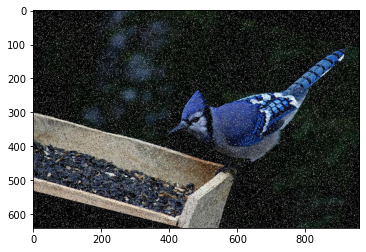

In [16]:
image = cv2.imread(x4['root'][17]+x4['filename'][12])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

We have added noise to our images to help our model account for noisier images. The camera we deploy this model on may pick up dust or get scratched so we can rectify this issue by applying noise to our training images.

#### Random Rotation

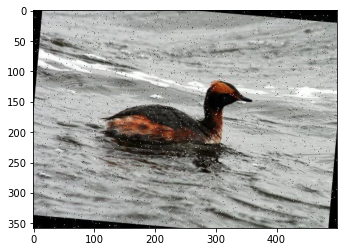

In [17]:
image = cv2.imread(x4['root'][26]+x4['filename'][26])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

We have added rotation to our images to help our model account for different roll orientations. This will help our model better predict a larger variety of image orientations.

#### Noise + Rotation

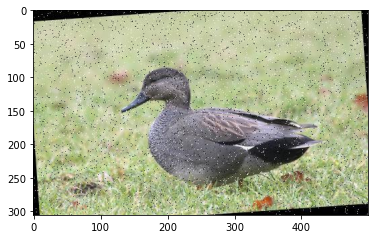

In [18]:
image = cv2.imread(x4['root'][47]+x4['filename'][54])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

A combination of both noise and rotation

In [19]:
#concat unaugmented and augmented metadata dataframe
train2=pd.concat((train1,x4),ignore_index=True)

In [20]:
train2.head(15)

,root,filename,w,h,x1,x2,y1,y2
0,../data/bird2_train/,Blue_Jay_00.jpg,600,391,102,445,52,333
1,../data/bird2_train/,Blue_Jay_001.jpg,960,640,403,835,72,435
2,../data/bird2_train/,Blue_Jay_00111.jpg,480,360,42,430,43,269
3,../data/bird2_train/,Blue_Jay_0031.jpg,570,380,257,487,60,309
4,../data/bird2_train/,Blue_Jay_00343.jpg,540,346,118,472,35,245
5,../data/bird2_train/,Blue_Jay_0038_62784.jpg,480,500,225,440,124,445
6,../data/bird2_train/,Blue_Jay_0044_62759.jpg,500,333,72,274,75,285
7,../data/bird2_train/,Blue_Jay_0048_62433.jpg,500,393,227,475,74,309
8,../data/bird2_train/,Blue_Jay_0049_63082.jpg,328,500,86,246,103,341
9,../data/bird2_train/,Blue_Jay_0050_62974.jpg,500,355,64,370,85,268


## Ground truth boxes 

Our ground truth boxes are our self-labeled bounding boxes of what we eventually want our model to detect. 

In [21]:
def bbox_plot(i):
    #function that plots an image and its associated boundary box
    image = cv2.imread(train2['root'][i]+train2['filename'][i])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1=train2['x1'][i]
    x2=train2['x2'][i]
    y1=train2['y1'][i]
    y2=train2['y2'][i]

    fig,ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor=np.random.rand(3,),facecolor='none')
    ##(x1,y1),x2-x1,y2-y1
    ax.add_patch(rect)
    print(x1,x2,y1,y2)
    return plt.imshow(image)

In [22]:
def bbox_plot1(i):

    image = cv2.imread(test1['root'][i]+test1['filename'][i])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1=test1['x1'][i]
    x2=test1['x2'][i]
    y1=test1['y1'][i]
    y2=test1['y2'][i]

    fig,ax = plt.subplots(1)
    ax.imshow(image)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor=np.random.rand(3,),facecolor='none')
    ##(x1,y1),x2-x1,y2-y1
    ax.add_patch(rect)
    print(x1,x2,y1,y2)
    return plt.imshow(image)

108 385 91 280


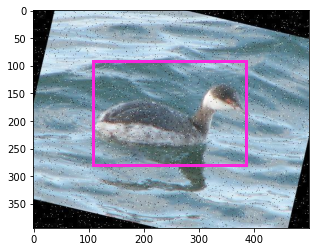

In [23]:
bbox_plot(291)

Image with ground truth box on a rotated image.

66 278 88 340


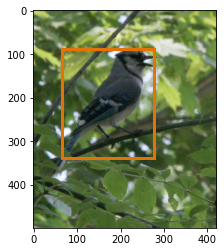

In [24]:
bbox_plot1(12)

Image with ground truth box on an unaugmented image.

## Region Proposal System

In [25]:
#https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/
#https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/

In [26]:
#http://www.huppelen.nl/publications/selectiveSearchDraft.pdf

We're going to be using OpenCVs selective search segmentation algorithm. Please refer to the above paper if you would like a more in depth look of how Selective Search was built off its predecessors. In general, Selective Search applies a wide variety of algorithms on multiples scales and looks to segment out images. The segmentations are based on region characteristics and similarities in color,texture, and size. OpenCVs method of segmentations returns the coordinates for us in a bounding box format.

### Segmentation Examples

In [27]:
#read in our image and convert to color
image = cv2.imread(train2['root'][14]+train2['filename'][14])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

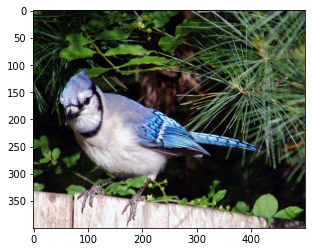

In [28]:
plt.imshow(image)

Basic color image of our cardinal we want to segment.

In [29]:
cv2.setUseOptimized(True)

In [30]:
##Initiate Segmentation
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
##Set base image to our specific ingest image
ss.setBaseImage(image)

In [31]:
%%time
##Selecting Quality Search over Fast, lower recall rate but higher rate of proposals
##(refer to #http://www.huppelen.nl/publications/selectiveSearchDraft.pdf)
ss.switchToSelectiveSearchFast()
##Process our image
rects = ss.process()
print(f'we have {len(rects)} proposals')

we have 2263 proposals
Wall time: 4.19 s


As we see above, ss.process() returns x1,y1, w,h coordinates of its segmented regions. Lets display the top 200 proposals from our algorithm.

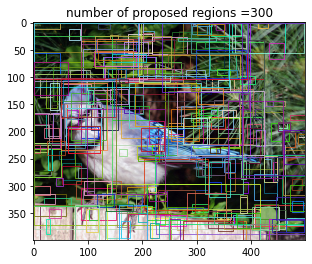

In [32]:
imOut = image.copy()
fig,ax = plt.subplots(1)
t1=300
#loop through proposal coordinates
for i, rect in enumerate(rects):
    #for proposal count less than our threshold, display these proposals on our image
    if (i < t1):
        x, y, w, h = rect
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor=np.random.rand(3,),facecolor='none')
        ax.add_patch(box)
plt.title(f'number of proposed regions ={t1}')
    
plt.imshow(imOut)

One of our cardinal images that has been segmented with Quality Segmentation. Top 300 Regions.

In [33]:
def segment_im(index):
    image = cv2.imread(test1['root'][index]+test1['filename'][index])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    print(f'we have {len(rects)} proposals')
    imOut = image.copy()
    fig,ax = plt.subplots(1)
    t1=200
    for i, rect in enumerate(rects):
        if (i < t1):
            x, y, w, h = rect
            box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor=np.random.rand(3,),facecolor='none')
            ax.add_patch(box)
    plt.title(f'number of proposed regions ={t1}')

        
    plt.imshow(imOut)

we have 1410 proposals


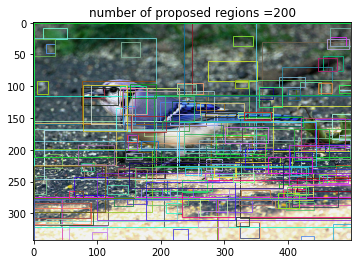

In [34]:
segment_im(13)

Above we have an example of 200 segmented regions on animage

we have 466 proposals


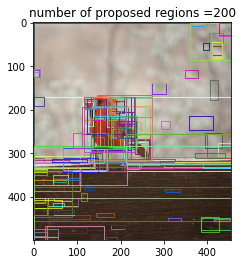

In [35]:
segment_im(19)

## Calculate Intersection over Unioin

In [36]:
#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

The IoU is a ratio or 'score' associating how overlapped the proposed regions with our ground truth boxes. This is a common technique in object detection. A score of 1 is one box totally overlaps the other, and 0 is there is no overlap. For our binary classification problem, we will assign 1 to regions with a score of over 0.7 and 0 to regions with an IoU score of 0.3 and assign nothing to those inbetween. So we will be training a binary classification model on these two different kinds of images. 

In [37]:
def calc_iou(box1,box2):

    left_max=max(box1['x1'],box2['x1'])
    right_min=min(box1['x2'],box2['x2'])
    top_min=min(box1['y2'],box2['y2'])
    bottom_max=max(box1['y1'],box2['y1'])
    
    if right_min < left_max or top_min < bottom_max:
        return 0.0
    
    area_of_intersect=(right_min-left_max)*(top_min-bottom_max)
    area_of_union=((box1['y2']-box1['y1'])*(box1['x2']-box1['x1']))+((box2['y2']-box2['y1'])*(box2['x2']-box2['x1']))-area_of_intersect
    iou=(area_of_intersect)/(area_of_union)


    return iou

### High IoU Score Examples

In [38]:
image = cv2.imread(test1['root'][43]+test1['filename'][43])
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

In [40]:
box1={}
box1['x1']=round(float(test1['x1'][43]))
box1['x2']=round(float(test1['x2'][43]))
box1['y1']=round(float(test1['y1'][43]))
box1['y2']=round(float(test1['y2'][43]))

Text(0.5, 1.0, '6 Regions w. IoU > 0.7')

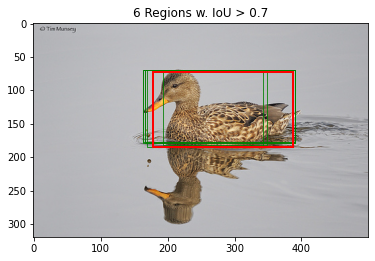

In [41]:
fig,ax = plt.subplots(1)
count=0
for i,item in enumerate(rects):
    box2={}
    box2['x1']=rects[i][0]
    box2['y1']=rects[i][1]
    box2['x2']=rects[i][0]+rects[i][2]
    box2['y2']=rects[i][1]+rects[i][3]
    iou=calc_iou(box1,box2)
    if iou>0.7:
        x, y, w, h = rects[i]
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='green',facecolor='none')
        ax.add_patch(box)

        count+=1
box3=patches.Rectangle((box1['x1'],box1['y1']),box1['x2']-box1['x1'],box1['y2']-box1['y1'],linewidth=2,edgecolor='red',facecolor='none')
ax.add_patch(box3)
plt.imshow(image)
plt.title(f'{count} Regions w. IoU > 0.7')

Above we have an image of one our birds that has been undergone segmentation and IoU calculation. Red box is our ground truth box. Green boxes are segmentations with IoU score > 0.7

In [42]:
def high_iou(index):
    image = cv2.imread(train2['root'][index]+train2['filename'][index])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    len(rects)
    box1={}
    box1['x1']=round(float(train2['x1'][index]))
    box1['x2']=round(float(train2['x2'][index]))
    box1['y1']=round(float(train2['y1'][index]))
    box1['y2']=round(float(train2['y2'][index]))
    fig,ax = plt.subplots(1)
    count=0
    for i,item in enumerate(rects):
        box2={}
        box2['x1']=rects[i][0]
        box2['y1']=rects[i][1]
        box2['x2']=rects[i][0]+rects[i][2]
        box2['y2']=rects[i][1]+rects[i][3]
        iou=calc_iou(box1,box2)
        if iou>0.7:
            x, y, w, h = rects[i]
            box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='green',facecolor='none')
            ax.add_patch(box)

            count+=1
    box3=patches.Rectangle((box1['x1'],box1['y1']),box1['x2']-box1['x1'],box1['y2']-box1['y1'],linewidth=2,edgecolor='red',facecolor='none')
    ax.add_patch(box3)
    plt.imshow(image)
    plt.title(f'{count} Regions w. IoU > 0.7')
    

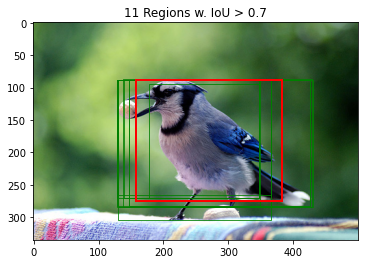

In [43]:
high_iou(15)

Above we have an example of an unaugmented image with 11 proposed regions with an IoU over 0.7

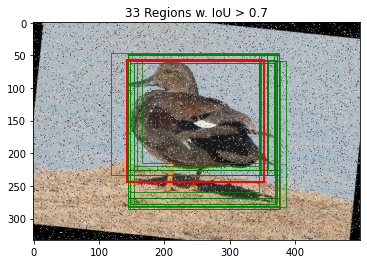

In [44]:
high_iou(293)

Above we have an example of an unaugmented image with 3 proposed regions with an IoU over 0.7

In [45]:
print(train2.shape)
test1.shape

(646, 8)


(102, 8)

## Model Setup

#### WARNING Long Process time. Preforming segmentation on our training data set.

This tidbit of code will set up our binary classifier data but cropping out all the segments with greater than 0.7 IoU score, resizing them all to same size (need to do this to fit a model) and then appending them to our data set with a label of 1 for >0.7 IoU or 0 for <0.4 IoU score. We will disregard regions in between. Since all of our observations have to have the same number of features, we resize each segment to a 224x224 image using cv2 inter_area interpolation method. This method applies an appropriate shrinking/enlarging resizing method depending on the relative size of the original image to the resize parameters. this is the article reffered [here](https://medium.com/@wenrudong/what-is-opencvs-inter-area-actually-doing-282a626a09b3).

In [46]:
#Initiate training data set
train_images=[]
train_labels=[]

In [47]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [48]:
##code adopted from 
##https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

#loop through our dataframe and get our image filenames to read in
for i,item in enumerate(train2['filename']):
    try:
        #get our ground truth box
        box1={}
        box1['x1']=round(float(train2['x1'][i]))
        box1['x2']=round(float(train2['x2'][i]))
        box1['y1']=round(float(train2['y1'][i]))
        box1['y2']=round(float(train2['y2'][i]))
        
        
        #read in image
        image = cv2.imread(train2['root'][i]+train2['filename'][i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #run selective search
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        imout=image.copy()
        
        #we want to set some limits to the number of classes we assign per image
        #we dont want to have unbalanced classes so we set a limit of 30 regions per image per label
        counter1=0
        counter2=0
        flag=0
        fflag=0
        bflag=0
        ##loop through proposed regions
        for j,item in enumerate(rects):
            #get top 2000 regions
            if j<2000 and flag==0:
                #assign proposed region coordinates to coordinate dictionary, similiar to our ground truth box.
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                #calculate IoU score of ground truth with proposal
                iou_score=calc_iou(box1,box3)
                #check to make sure there are less than 40 positive classes for this image
                if counter1<30:
                    #if IoU score is high, greater than 0.7 lets assign it to positive class 1
                    if iou_score>0.7:
                        #crop out proposal
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                        #resize for model input resampling using pixel area relation
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        #add image data to our train set
                        train_images.append(resized)
                        #append positive class
                        train_labels.append(1)
                        #increment counter
                        counter1+=1
                       # print('yes')
                else:
                    fflag=1
                if counter2<20:
                    #if iou_score is low, less than 0.3 lets assign it to negative class 0
                    if iou_score<0.3:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']] 
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(0)
                        counter2+=1
                
                else:
                    bflag=1
            #If we have 70 regions for botch classes within the image, we move on        
            if fflag==1 and bflag==1:
               # print('inside')
                flag=1
    except Exception as j:
        print(j)
                        
X_train=np.array(train_images)            
y_train=np.array(train_labels)        

### Preform same steps on test data

We will preform the exact same preprocessing steps to our test data, refer to above cells.

In [49]:
test_images=[]
test_labels=[]

In [50]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [51]:
for i,item in enumerate(test1['filename']):
    try:

        box1={}
        box1['x1']=round(float(test1['x1'][i]))
        box1['x2']=round(float(test1['x2'][i]))
        box1['y1']=round(float(test1['y1'][i]))
        box1['y2']=round(float(test1['y2'][i]))
        
        
        
        image = cv2.imread(test1['root'][i]+test1['filename'][i])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ss.setBaseImage(image)

        
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        imout=image.copy()
        
        counter1=0
        counter2=0
        flag=0
        fflag=0
        bflag=0
        for j,item in enumerate(rects):
            if j<2000 and flag==0:
                box3={}
                box3['x1']=rects[j][0]
                box3['y1']=rects[j][1]
                box3['x2']=rects[j][0]+rects[j][2]
                box3['y2']=rects[j][1]+rects[j][3]
                iou_score=calc_iou(box1,box3)
                if counter1<40:
                    if iou_score>0.7:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']]
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(1)
                        counter1+=1
                       # print('yes')
                else:
                    fflag=1
                if counter2<40:
                    if iou_score<0.3:
                        timage=imout[box3['y1']:box3['y2'],box3['x1']:box3['x2']] 
                        resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                        test_images.append(resized)
                        test_labels.append(0)
                        counter2+=1
                
                else:
                    bflag=1
                    
            if fflag==1 and bflag==1:
               # print('inside')
                flag=1
    except Exception as j:
        print(j)
        
X_test=np.array(test_images)            
y_test=np.array(test_labels)    

### Positive samples

In [52]:
pos_sam=[]
for i,j in enumerate(train_labels):
    if j==1:
        pos_sam.append(i)   

In [53]:
choices_pos=random.choices(pos_sam, k=3)

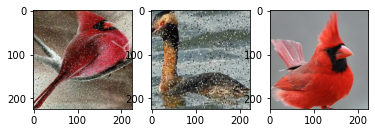

In [54]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(train_images[choices_pos[0]])
ax2.imshow(train_images[choices_pos[1]])
ax3.imshow(train_images[choices_pos[2]])


Above we have 3 examples of positive samples. These samples all had an IoU score above 0.7 with our ground truth box.

### Negative samples

In [55]:
neg_sam=[]
for i,j in enumerate(train_labels):
    if j==0:
        neg_sam.append(i)    

In [56]:
choices_neg=random.choices(neg_sam, k=4)

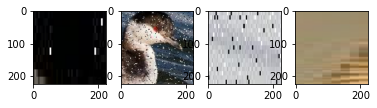

In [57]:
fig,(ax1,ax2,ax3,ax4)=plt.subplots(1,4)
ax1.imshow(train_images[choices_neg[0]])
ax2.imshow(train_images[choices_neg[1]])
ax3.imshow(train_images[choices_neg[2]])
ax4.imshow(train_images[choices_neg[3]])

Above we have 4 examples of negative samples. These samples all had an IoU score below 0.3 with our ground truth box.

Above we have an example of 200 segmented regions on animage

### Check class splits

In [58]:
#train split
count1=0
for i,j in enumerate(train_labels):
    if j==1:
        count1+=1
print(f'Positive class proportion:{round(count1/len(train_labels),3)} Negative class proportion:{round(1-count1/len(train_labels),3)}')

Positive class proportion:0.274 Negative class proportion:0.726


In [59]:
#test split
count1=0
for i,j in enumerate(test_labels):
    if j==1:
        count1+=1
print(f'Positive class proportion:{round(count1/len(test_labels),3)} Negative class proportion:{round(1-count1/len(test_labels),3)}')

Positive class proportion:0.212 Negative class proportion:0.788


Our train class split is 72.6% positive 27.4% negative, test split is 78.8% positive and 21.2% negative. We have unbalanced classes, which is the nature of our data since there are far fewer samples with an IoU > 0.7. 

## Modeling

### Baseline

First, let us determine a baseline accuracy score to compare against. We are building a binary classification model, but our classes arent balanced. We have 4873 positive classes and 12920 negative classes. Our baseline is our majority class proportion within our data set. So our baseline is 12920/17793 = 0.726  
Since we are evaluating our model on accuracy, our baseline is 72.6% accuracy

## Binary Classifier with CNN

Our Convolutional neural network has two blocks including a convulation layer, batch normalization for regularization, activation, and mox pooling. This is connected to a fully connected neural network with two dense layers and 0.3 dropout.

In [60]:
X_train.shape

(17801, 224, 224, 3)

In [61]:
cnn=Sequential()
cnn.add(Conv2D(32,(3,3),input_shape=(224,224,3)))
cnn.add(BatchNormalization()) 
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))

cnn.add(Conv2D(64,(3,3)))
cnn.add(BatchNormalization()) 
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D((2,2), strides=(2,2)))
        
cnn.add(Flatten())
        

cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.3))

#30 epochs, 95.63 test, 99.24 train

In [62]:
cnn.add(Dense(1,activation='sigmoid'))


In [63]:
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [64]:
early_stop=EarlyStopping(monitor='binary_accuracy',min_delta=0,patience=5,verbose=1,mode='auto')

In [65]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 64)      0

In [66]:
history1 = cnn.fit(X_train,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        epochs=60,
                        verbose=1,callbacks=[early_stop])

Train on 17801 samples, validate on 5176 samples
Epoch 1/60
17801/17801 [==============================] - 106s 6ms/sample - loss: 3.5821 - binary_accuracy: 0.8285 - val_loss: 0.3988 - val_binary_accuracy: 0.8590
Epoch 2/60
17801/17801 [==============================] - 97s 5ms/sample - loss: 0.3343 - binary_accuracy: 0.8676 - val_loss: 0.5833 - val_binary_accuracy: 0.8510
Epoch 3/60
17801/17801 [==============================] - 99s 6ms/sample - loss: 0.3582 - binary_accuracy: 0.8565 - val_loss: 0.3246 - val_binary_accuracy: 0.8454
Epoch 4/60
17801/17801 [==============================] - 100s 6ms/sample - loss: 0.3280 - binary_accuracy: 0.8779 - val_loss: 0.5700 - val_binary_accuracy: 0.8439
Epoch 5/60
17801/17801 [==============================] - 100s 6ms/sample - loss: 0.2695 - binary_accuracy: 0.8947 - val_loss: 0.4443 - val_binary_accuracy: 0.9007
Epoch 6/60
17801/17801 [==============================] - 100s 6ms/sample - loss: 0.2257 - binary_accuracy: 0.9135 - val_loss: 1.0403

## Results & Evaluation

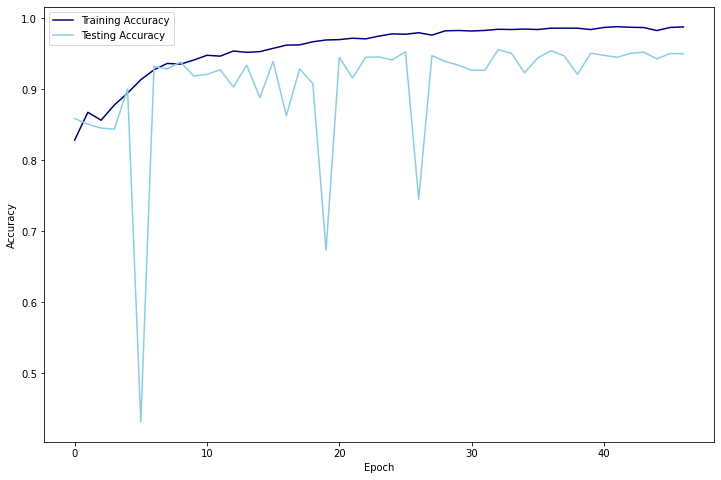

In [116]:
train_loss=history1.history['binary_accuracy']
test_loss=history1.history['val_binary_accuracy']
plt.figure(figsize=(12,8))
plt.plot(train_loss,label='Training Accuracy', color='navy')
plt.plot(test_loss,label='Testing Accuracy',color='skyblue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

As we can see from our loss graph above, our model training and testing accuracy following similiar overall trajectories. Our testing accuracy has large dips in accuracy which are not present in our training accuracy. We do see this dips start to minimize further into training. This volatitlity could be attributed to the small size of the test data (5176 observations), and the presence of augmentation only in our training set. Smaller data sets would be more prone to these spikes since a change in our model could reclassify a relatively large portion of our testing samples over one epoch.

In [119]:
preds=cnn.predict(X_test)
test2=pd.DataFrame(y_test)
preds=pd.DataFrame(preds)

In [120]:
x=pd.concat((preds,test2),axis=1,ignore_index=False)

In [121]:
x.columns = ['pbird','isbird']

In [122]:
TP=x[(x['pbird']>0.5)&(x['isbird']==1)].shape[0]
TN=x[(x['pbird']<0.5)&(x['isbird']==0)].shape[0]
FP=x[(x['pbird']>0.5)&(x['isbird']==0)].shape[0]
FN=x[(x['pbird']<0.5)&(x['isbird']==1)].shape[0]


## Confusion Matrix

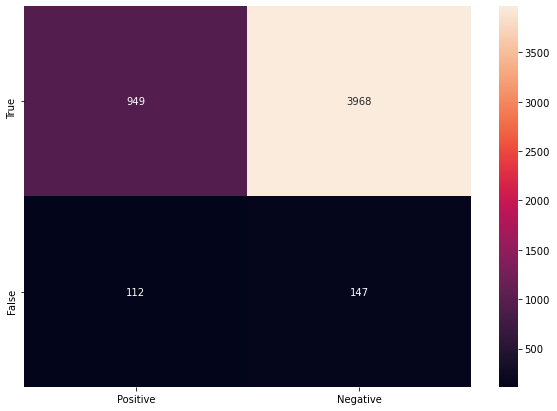

In [123]:
array = [[TP,TN],
        [FP,FN]]
df_cm = pd.DataFrame(array, index = ['True','False'],
                  columns = ['Positive','Negative'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='1g')

Above we have our confusion matrix describing the performancy of our binary classification model on our test set. One important error class we have to consider heavily here is our False Positives, type 1 error. These are segments predicted to be positive but are negative. They will interfere heavily with object detection. Our False Positive rate is given by FP/(FP+TN)=112/4080= 2.745% . We want this to essentially be 0. We have an accuracy of 95%, a true positive rate of 86.6%, and a true negativer rate of 97.25% 

### True Positives

Correct positive predictions

In [124]:
choices_tp=random.choices(list(x[(x['pbird']>0.5)&(x['isbird']==1)].index),k=3)

In [125]:
TP

949

Text(0.5, 1.0, '0.56541')

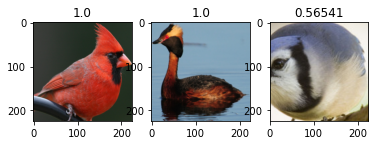

In [126]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(X_test[choices_tp[0]])
ax1.set_title(f'{round(x.loc[choices_tp[0]][0],5)}')
ax2.imshow(X_test[choices_tp[1]])
ax2.set_title(f'{round(x.loc[choices_tp[1]][0],5)}')
ax3.imshow(X_test[choices_tp[2]])
ax3.set_title(f'{round(x.loc[choices_tp[2]][0],5)}')

Above we have chosen 3 true positives from our testing set. These are positive samples that were predicted to be positive. Above each image we have the probability of positive sample. All images were properly classified.

### True Negatives

correct negative predictions

In [127]:
TN

3968

In [128]:
choices_tn=random.choices(list(x[(x['pbird']<0.5)&(x['isbird']==0)].index),k=3)

Text(0.5, 1.0, '0.0')

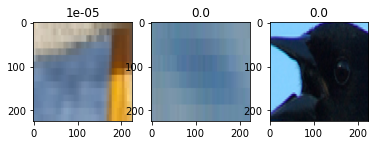

In [129]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(X_test[choices_tn[0]])
ax1.set_title(f'{round(x.loc[choices_tn[0]][0],5)}')
ax2.imshow(X_test[choices_tn[1]])
ax2.set_title(f'{round(x.loc[choices_tn[1]][0],5)}')
ax3.imshow(X_test[choices_tn[2]])
ax3.set_title(f'{round(x.loc[choices_tn[2]][0],5)}')

We have randomly chosen 3 true negative examples from our test data. All of these examples are negative samples from our testing set that were correctly predicted negative. Above each image we have the probability that each sample is positive. We see only the left most is non-zero with 0.00005 chance positive. 

### False Positives

incorrect positive predictions

In [130]:
FP

112

In [131]:
choices_fp=random.choices(list(x[(x['pbird']>0.5)&(x['isbird']==0)].index),k=3)

Text(0.5, 1.0, '0.59063')

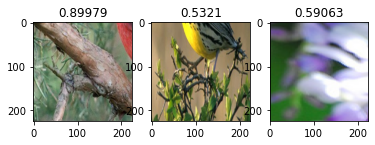

In [132]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(X_test[choices_fp[0]])
ax1.set_title(f'{round(x.loc[choices_fp[0]][0],5)}')
ax2.imshow(X_test[choices_fp[1]])
ax2.set_title(f'{round(x.loc[choices_fp[1]][0],5)}')
ax3.imshow(X_test[choices_fp[2]])
ax3.set_title(f'{round(x.loc[choices_fp[2]][0],5)}')

Here we have our false positives, these were all segmented regions classified as negative that were predicted to be positive with their associated probabilities. We see the negative sample on the right is right above the 0.5 threshold. The negative sample in the middle is clearly the bottom of a bird and also right above the 0.5 threshold, which makes sense since it this segment techincally shares our two classes. We may have to raise our IoU threshold to help our network discren between our two classes. Our False Positive rate is really improtant to minimize since when we want to predict where an object is on an image, and having random noise be predicted to be our object would ruin the whole concept. We can also adjust our threhold to minimize false positives.

### False Negatives

incorrect negative predictions

In [133]:
FN

147

In [138]:
choices_fn=random.choices(list(x[(x['pbird']<0.5)&(x['isbird']==1)].index),k=3)

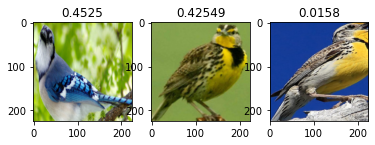

In [139]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
ax1.imshow(X_test[choices_fn[0]])
ax1.set_title(f'{round(x.loc[choices_fn[0]][0],5)}')
ax2.imshow(X_test[choices_fn[1]])
ax2.set_title(f'{round(x.loc[choices_fn[1]][0],5)}')
ax3.imshow(X_test[choices_fn[2]])
ax3.set_title(f'{round(x.loc[choices_fn[2]][0],5)}');

Above we have 3 false negatives, segments that were predicted to be negative(background) but are positive(bird). The two images on the left almost reach our threshold. On the right we have a more worrying prediction. We dont have to worry about false negatives as much since we will have enough truepositives to properly detect the image.

## AUC-ROC Curve

0.9857784993559469


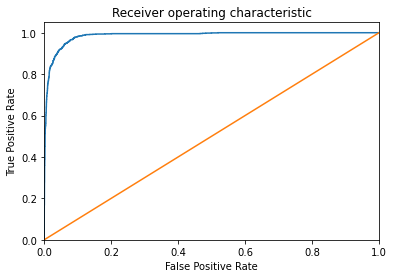

In [85]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, np.array(preds[0]))
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test, np.array(preds[0])))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.plot(np.linspace(0,1,100),
        np.linspace(0,1,100))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

Above we have our ROC curve showing the trade off between our true positive and false positive rates. Our best location along the curve for accuracy is the point closest to the 1 on the y axis in the top left corner. As discussed, we want to minimize our false positive rate to 0. We will also be minimizing our true positive rate, as you can tell on the graph. This is OK since we essentially only need 1 correct prediction for our object detector to work.

## Deployment

In [267]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

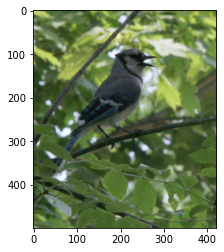

In [268]:
##read in test image
image = cv2.imread(test1['root'][1]+test1['filename'][12])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Original test image

In [283]:
#segment out image
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
rects = ss.process()

In [284]:
test_sample=[]
items=[]
imout=image.copy()
#grab top 700 regions for predicting
for i,item in enumerate(rects):
    if i<700:
        items.append(item)
        x1=item[0]
        y1=item[1]
        x2=item[0]+item[2]
        y2=item[1]+item[3]
        cimage=imout[y1:y2,x1:x2]
        cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
        test_sample.append(cimage)
test_sample_array=np.array(test_sample)

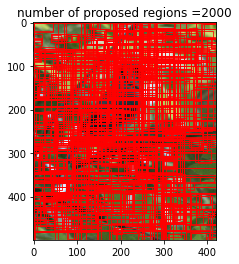

In [285]:
imOut = image.copy()
fig,ax = plt.subplots(1)
t1=2000
#loop through proposal coordinates
for i, rect in enumerate(rects):
    #for proposal count less than our threshold, display these proposals on our image
    if (i < 2000):
        x, y, w, h = rect
        box=patches.Rectangle((x,y),w,h,linewidth=0.8,edgecolor='red',facecolor='none')
        ax.add_patch(box)
plt.title(f'number of proposed regions ={t1}')
plt.imshow(imOut)

Top 1000 segments for our first test image.

### Predictions 

In [286]:
#lets use our cnn on our segments, so we are classifying each above segment as foreground or background.
test_sample_preds=cnn.predict(test_sample_array)

In [287]:
fore=[]
w=image.shape[1]
h=image.shape[0]
#append positive samples above threshold to our list
for sample,label in zip(items,test_sample_preds):
    if label>.85:
        #filter out bad suggestions that touch borders of image
        fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))

        fore.append(sample)
    

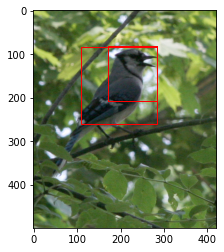

In [288]:
fig,ax=plt.subplots(1)
for i in fore:
    x,y,w,h=i
    box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
    ax.add_patch(box)
    
plt.imshow(image)

Predictions for one test image.

In [289]:
def det_obj(filename,threshold):
    '''function that reads a certain file and prediction threshold and uses our model to predict object of interest'''
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    w=image.shape[1]
    h=image.shape[0]
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    print(len(rects))
    rects[:10]
    test_sample=[]
    items=[]
    imout=image.copy()
    for i,item in enumerate(rects):
        if i<1000:
            ##add segments to empty list
            items.append(item)
            x1=item[0]
            y1=item[1]
            x2=item[0]+item[2]
            y2=item[1]+item[3]
            cimage=imout[y1:y2,x1:x2]
            cimage=cv2.resize(cimage,(224,224),interpolation=cv2.INTER_AREA)
            test_sample.append(cimage)
    test_sample_array=np.array(test_sample)   
    #predict all samlpes in our list
    test_sample_preds=cnn.predict(test_sample_array)
    fore=[]
    fore_score=[]
    for sample,label in zip(items,test_sample_preds):
        if label>threshold:
            fore = list(filter(lambda x : x[0]!=0 and x[1]!=0 and x[0]+x[2]<w and x[1]+x[3]<h, fore))
            #append positive samples above threshold
            fore.append(sample)
            
    fig,ax=plt.subplots(1)
    for i in fore:
        #place detections on image
        x,y,w,h=i
        box=patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='red',facecolor='none')
        ax.add_patch(box)
        
    plt.imshow(image)
    

646


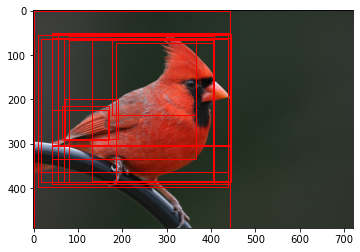

In [266]:
det_obj(test1['root'][1]+test1['filename'][31],.95)

1132


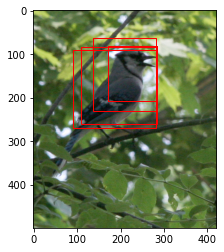

In [241]:
det_obj(test1['root'][1]+test1['filename'][12],.95)

1108


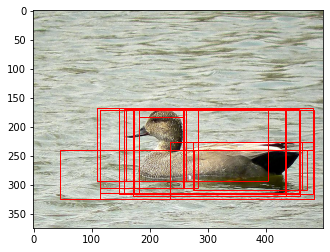

In [242]:
det_obj(test1['root'][1]+test1['filename'][41],.95)

594


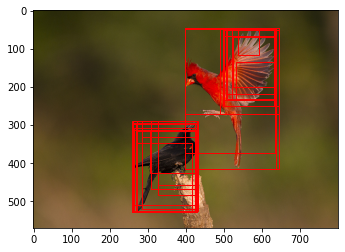

In [256]:
det_obj('../data/AT1F6839-Northern-Cardinal-&-Redwing-Blackbird-_-800.jpg',.95)

## Conclusion and Recommendations.

We trained a CNN to achieve 95% testing accuracy and 98.8% training accuracy, which is significantly higher than our 50% baseline model. Looking over our false positives and false negatives, our model still needs some fine tuning as the presence of false positives will greatly interfere with our detection process. A relatively small sample size was used, we had around 300 images that segmented out to around 22k observations with a 17k/5k train test split. We also must take note that our positive samples also include background noise that can be considered a negative class. Our predictions are not perfect pixel-for-pixel representations of what we are actually detection, our bird. So different species of birds will tend to have different background noise that we will also be classifying on, when in actuality we dont want the extra noise in our computation.

For further steps, we can also use GridSearch, and ModelCheckpoints in the tune our CNN and deploy it in the setting we are targeting. Now that we have a pool of objects that we have detected, we notice there are multiple predictions per object. We can apply different suppression techniques to choice the best proposal within a cluster of proposals which we can then push through another multi-classification problem.

## Sources

- https://medium.com/@wenrudong/what-is-opencvs-inter-area-actually-doing-282a626a09b3
- https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55
- https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/
- https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
- http://www.huppelen.nl/publications/selectiveSearchDraft.pdf